# Imports

In [109]:
import re
import glob
import functools
import os
import gzip
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [118]:
'dropoffs_barclays_center_0.003.csv.gz'[len('dropoffs_'):-len('_0.003.csv.gz')].replace('_', ' ')

'barclays center'

In [129]:
def venue_name(file):
    return os.path.basename(file)[len('dropoffs_'):-len('_0.003.csv.gz')].replace('_', ' ')

def for_d3(file):
    idx = pd.Series(0, index=pd.date_range('2016-01-01', '2016-09-01', freq='H'), name='all_ts')\
        .asfreq('30Min', method='pad')
    df = pd.read_csv(gzip.open(file), delimiter=',')\
        .assign(minute=lambda df: df.minute * 30)\
        .assign(time=lambda df: df.date.astype(str) + ' ' + df.hour.astype(str).str.zfill(2) + ':' + df.minute.astype(str).str.zfill(2))\
        [['time', 'dropoffs']]\
        .set_index('time')
    return df\
        .join(idx, how='right')\
        .fillna(0)\
        [lambda df2: df2.index <= df.index.max()]\
        .reset_index()\
        .rename(columns={'index': 'time'})\
        .assign(dropoffs=lambda df: df.dropoffs.astype(int))\
        .drop('all_ts', axis=1)\
        .assign(venue=venue_name(file))

In [127]:
def dropoffs_all():
    df_all = None
    for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
        if df_all is None:
            df_all = for_d3(f)
        else:
            df_all = pd.concat([df_all, for_d3(f)])
    df_all.to_csv(os.path.join('for_d3', 'dropoffs.csv'), index=False)

dropoffs_all()

In [107]:
def yearly_stats_for_d3(file):
    df = for_d3(file)
    return df.mean()[0], (df.dropoffs.min() - df.mean())[0], (df.dropoffs.max() - df.mean())[0]

In [108]:
yearly_stats_for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz'))

(45.91162737729188, -45.91162737729188, 204.0883726227081)

In [143]:
def all_venues_yearly_stats():
    with open(os.path.join('for_d3', 'overall_mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,mean,min_below,max_above\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            stats = yearly_stats_for_d3(f)
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in stats) + '\n')
            
all_venues_yearly_stats()

In [144]:
def all_venues_hourly_stats():
    with open(os.path.join('for_d3', 'hourly_mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,' + ','.join(str(i) for i in range(24)) + '\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            hourly_mean = for_d3(f).assign(hour=lambda df: df.time.dt.hour).groupby('hour').mean()
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in list(hourly_mean.dropoffs)) + '\n')
            
all_venues_hourly_stats()

In [141]:
list(for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).assign(hour=lambda df: df.time.dt.hour).groupby('hour').mean().dropoffs)

[80.48633879781421,
 60.53005464480874,
 41.333333333333336,
 26.136612021857925,
 15.079234972677595,
 6.409836065573771,
 6.060109289617486,
 9.592896174863387,
 13.415300546448087,
 22.10928961748634,
 30.404371584699454,
 36.666666666666664,
 43.177595628415304,
 42.20765027322405,
 39.84699453551912,
 37.69945355191257,
 35.17486338797814,
 45.01092896174863,
 72.77595628415301,
 90.96994535519126,
 91.18032786885246,
 87.60109289617486,
 82.62465753424658,
 85.7032967032967]

In [ ]:
def all_venues_yearly_stats():
    with open(os.path.join('for_d3', 'mean_dropoffs.csv'), 'w') as f_out:
        f_out.write('venue,mean,min_below,max_above\n')
        for f in glob.glob(os.path.join('data', 'dropoffs*0.003.csv.gz')):
            stats = yearly_stats_for_d3(f)
            f_out.write(venue_name(f) + ',' + ','.join(str(e) for e in stats) + '\n')
            
all_venues_yearly_stats()

In [88]:
for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz')).head()

,time,dropoffs
0,2016-01-01 00:00:00,72
1,2016-01-01 00:30:00,94
2,2016-01-01 01:00:00,106
3,2016-01-01 01:30:00,109
4,2016-01-01 02:00:00,90


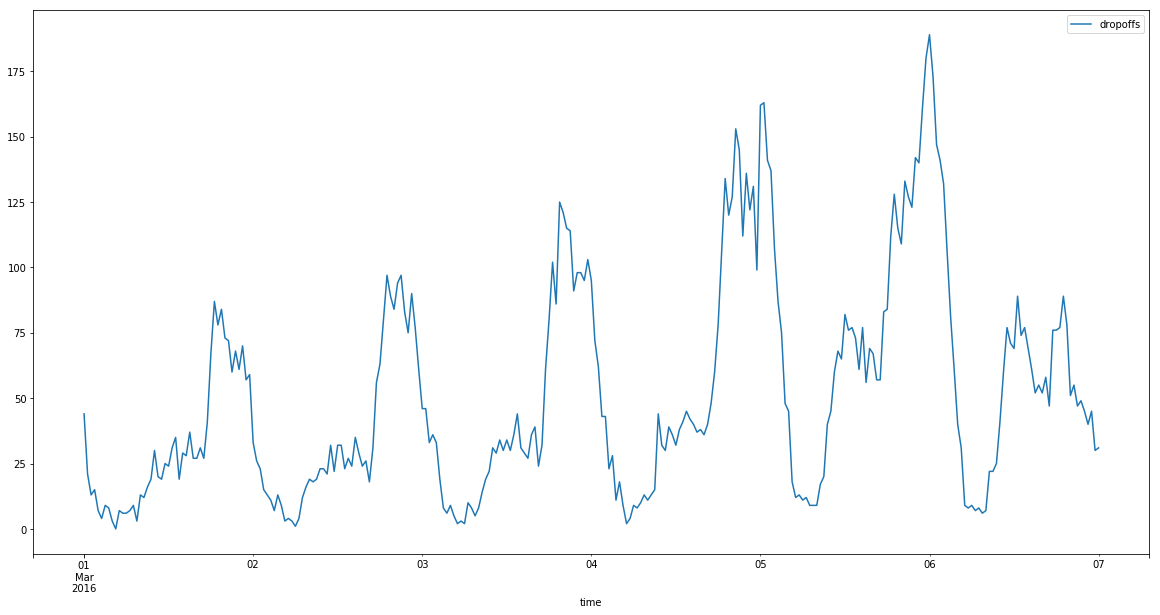

In [95]:
for_d3(os.path.join('data', 'dropoffs_bowery_ballroom_0.003.csv.gz'))\
    [lambda df: df.time <= '2016-03-07']\
    [lambda df: df.time >= '2016-03-01']\
    .set_index('time').plot()